In [1]:
# fake BEPS generator
from __future__ import division, print_function, unicode_literals, absolute_import
import os
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import pandas as pd
import sys
from PIL import Image
from scipy.special import erf

import pycroscopy as px

In [2]:
max_mem         = 1024*8  # Maximum memory to use, in Mbs. Default = 1024
max_cores       = None    # Number of logical cores to use in fitting.  None uses all but 2 available cores.

In [3]:
# Set-up parameters and file paths
data_type = 'BEPSData'
mode = 'DC modulation mode'
field_mode = 'in and out-of-field'

cwd = os.getcwd()
image_folder = px.io.translators.df_utils.beps_gen_utils.beps_image_folder

# Define the dimensions
binning_factor = 4    # Factor by which to downsample the images
n_steps = 64          # Number of UDVS steps per cycle
n_bins = 77           # Number of frequency bins
w1 = 250E3            # Starting frequency
w2 = 325E3            # Ending frequency
FORC_cycles = 3
FORC_repeats = 2
n_cycles = 2

# Define the loop coefficients
a = 1
b = 4

# Path to the HDF5 file that will be created
h5_path = os.path.join(cwd, 'fake.h5')

In [6]:
# Generate the data using the input parameters
fdg = px.FakeDataGenerator(max_mem)
h5_path = fdg.translate(h5_path, n_steps, n_bins, w1, w2,
                        n_cycles=n_cycles, FORC_cycles=FORC_cycles,
                        FORC_repeats=FORC_repeats, loop_a=a, loop_b=b, data_type=data_type,
                        mode=mode, field_mode=field_mode, image_folder=image_folder, 
                        bin_factor=binning_factor)


Working on:
/home/challtdow/workspace/pycroscopy_data/fake.h5


In [4]:
# Open the H5 file and find the Raw_Data dataset
hdf = px.ioHDF5(h5_path)
print('Working on:\n' + h5_path)
h5_main = px.hdf_utils.getDataSet(hdf.file, 'Raw_Data')[-1]

Working on:
/home/challtdow/workspace/pycroscopy_data/fake.h5


##### Inspect the contents of this h5 data file
The file contents are stored in a tree structure, just like files on a conventional computer.
The data is stored as a 2D matrix (position, spectroscopic value) regardless of the dimensionality of the data. Thus, the positions will be arranged as row0-col0, row0-col1.... row0-colN, row1-col0.... and the data for each position is stored as it was chronologically collected  

The main dataset is always accompanied by four ancillary datasets that explain the position and spectroscopic value of any given element in the dataset.

In [5]:
print('Datasets and datagroups within the file:\n------------------------------------')
px.io.hdf_utils.print_tree(hdf.file)
 
print('\nThe main dataset:\n------------------------------------')
print(h5_main)
print('\nThe ancillary datasets:\n------------------------------------')
print(hdf.file['/Measurement_000/Channel_000/Position_Indices'])
print(hdf.file['/Measurement_000/Channel_000/Position_Values'])
print(hdf.file['/Measurement_000/Channel_000/Spectroscopic_Indices'])
print(hdf.file['/Measurement_000/Channel_000/Spectroscopic_Values'])

print('\nMetadata or attributes in a datagroup\n------------------------------------')
for key in hdf.file['/Measurement_000'].attrs:
    print('{} : {}'.format(key, hdf.file['/Measurement_000'].attrs[key]))

Datasets and datagroups within the file:
------------------------------------
/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000/Fit
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000/Guess
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000/Spectroscopic_Indices
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000/Spectroscopic_Values
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Guess
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Spectroscopic_Indices
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
Measurement_000/Channel_000/Spectroscopic_Indices
Measurement_000/Cha

In [6]:
h5_pos_inds = px.hdf_utils.getAuxData(h5_main, auxDataName='Position_Indices')[-1]
pos_sort = px.hdf_utils.get_sort_order(np.transpose(h5_pos_inds))
pos_dims = px.hdf_utils.get_dimensionality(np.transpose(h5_pos_inds), pos_sort)
pos_labels = np.array(h5_pos_inds.attrs['labels'])[pos_sort]
print(pos_labels, pos_dims)

parm_dict = hdf.file['/Measurement_000'].attrs
is_ckpfm = hdf.file.attrs['data_type'] == 'cKPFMData'
if is_ckpfm:
    num_write_steps = parm_dict['VS_num_DC_write_steps']
    num_read_steps = parm_dict['VS_num_read_steps']
    num_fields = 2

[b'X' b'Y'] [32, 32]


No position datasets found as attributes of /Measurement_000/Channel_000/Spectroscopic_Values


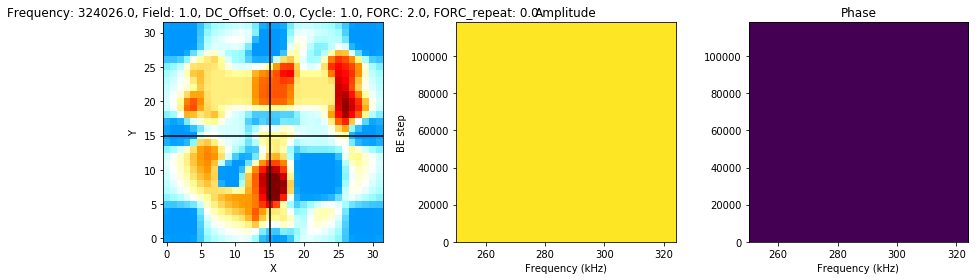

In [7]:
px.be_viz_utils.jupyter_visualize_be_spectrograms(h5_main)

In [8]:
# Get the generated SHO guess and fit
h5_sho_gen_group = px.hdf_utils.findH5group(h5_main, 'SHO_Fit')
h5_sho_gen_guess = h5_sho_gen_group[-1]['Guess']
h5_sho_gen_fit = h5_sho_gen_group[-1]['Fit']

# Do the fit on the generated Raw_Data
sho_fitter = px.BESHOmodel(h5_main, parallel=True)
h5_sho_guess = sho_fitter.do_guess(strategy='complex_gaussian', processors=max_cores)
h5_sho_fit = sho_fitter.do_fit(processors=max_cores)
h5_sho_group = h5_sho_guess.parent

Using complex_gaussian to find guesses...

Computing Jobs In parallel ... launching 2 kernels...
Extracted Results...
closing 2 kernels...
Completed computing guess. Writing to file.
Finished writing guess results to file!
Using solver least_squares and objective function SHO to fit your data

Computing Jobs In parallel ... launching 2 kernels...
closing 2 kernels...
Finished writing fit results to file!


In [9]:
h5_sho_spec_inds = px.hdf_utils.getAuxData(h5_sho_fit, auxDataName='Spectroscopic_Indices')[0]
sho_spec_labels = px.io.hdf_utils.get_attr(h5_sho_spec_inds,'labels')

if is_ckpfm:
    # It turns out that the read voltage index starts from 1 instead of 0
    # Also the VDC indices are NOT repeating. They are just rising monotonically
    write_volt_index = np.argwhere(sho_spec_labels == 'write_bias')[0][0]
    read_volt_index = np.argwhere(sho_spec_labels == 'read_bias')[0][0]
    h5_sho_spec_inds[read_volt_index, :] -= 1
    h5_sho_spec_inds[write_volt_index, :] = np.tile(np.repeat(np.arange(num_write_steps), num_fields), num_read_steps)

(Nd_mat, success) = px.io.hdf_utils.reshape_to_Ndims(h5_sho_fit)
print('Reshape Success: ' + str(success))

sho_spec_sort_order = px.hdf_utils.get_sort_order(h5_sho_spec_inds)
sho_spec_labels_sorted = sho_spec_labels[sho_spec_sort_order]

nd_labels = np.hstack((pos_labels, sho_spec_labels_sorted))
print(nd_labels)
print(Nd_mat.shape)

Reshape Success: True
['X' 'Y' 'Field' 'DC_Offset' 'Cycle' 'FORC' 'FORC_repeat']
(32, 32, 2, 64, 2, 3, 2)


In [10]:
px.be_viz_utils.jupyter_visualize_beps_sho(h5_sho_gen_fit, 'AC_Amplitude')

No position datasets found as attributes of /Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Spectroscopic_Indices
No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
px.be_viz_utils.jupyter_visualize_beps_sho(h5_sho_fit, 'AC_Amplitude')

In [ ]:
# Do the Loop Fitting on the SHO Fit dataset
loop_success = False
h5_loop_group = px.hdf_utils.findH5group(h5_sho_fit, 'Loop_Fit')
if len(h5_loop_group) == 0:
    try:
        loop_fitter = px.BELoopModel(h5_sho_fit, parallel=True)
        print('No loop fits found. Fitting now....')
        h5_loop_guess = loop_fitter.do_guess(processors=max_cores, max_mem=max_mem)
        h5_loop_fit = loop_fitter.do_fit(processors=max_cores, max_mem=max_mem)
        loop_success = True
    except ValueError:
        print('Loop fitting is applicable only to DC spectroscopy datasets!')
else:
    loop_success = True
    print('Taking previously computed loop fits')
    h5_loop_guess = h5_loop_group[-1]['Guess']
    h5_loop_fit = h5_loop_group[-1]['Fit']

In [ ]:
# Prepare some variables for plotting loops fits and guesses
# Plot the Loop Guess and Fit Results
if loop_success:
    h5_projected_loops = px.analysis.utils.be_loop.projectLoop()
    h5_proj_spec_inds = px.hdf_utils.getAuxData(h5_projected_loops, 
                                                auxDataName='Spectroscopic_Indices')[-1]
    h5_proj_spec_vals = px.hdf_utils.getAuxData(h5_projected_loops, 
                                                auxDataName='Spectroscopic_Values')[-1]

    # reshape the vdc_vec into DC_step by Loop
    sort_order = px.hdf_utils.get_sort_order(h5_proj_spec_inds)
    dims = px.hdf_utils.get_dimensionality(h5_proj_spec_inds[()], 
                                           sort_order[::-1])
    vdc_vec = np.reshape(h5_proj_spec_vals[h5_proj_spec_vals.attrs['DC_Offset']], dims).T

    #Also reshape the projected loops to Positions-DC_Step-Loop
    # Also reshape the projected loops to Positions-DC_Step-Loop
    proj_nd, _ = px.hdf_utils.reshape_to_Ndims(h5_projected_loops)
    proj_3d = np.reshape(proj_nd, [h5_projected_loops.shape[0], 
                                   proj_nd.shape[2], -1])

In [ ]:
use_static_plots = False
if loop_success:
    if not use_static_plots:
        try:
            px.be_viz_utils.jupyter_visualize_beps_loops(h5_projected_loops, h5_loop_guess, h5_loop_fit)
        except:
            print('There was a problem with the interactive visualizer')
            use_static_plots = True
    if use_static_plots:
        for iloop in range(h5_loop_guess.shape[1]):
            fig, ax = px.be_viz_utils.plot_loop_guess_fit(vdc_vec[:, iloop], proj_3d[:, :, iloop], 
                                          h5_loop_guess[:, iloop], h5_loop_fit[:, iloop],
                                          title='Loop {} - All Positions'.format(iloop))